In [241]:
import h5py
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

from collections import OrderedDict
from operator import itemgetter
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.utils import np_utils

%matplotlib inline

# Loading data

In [441]:
dataD = scipy.io.loadmat('./DataD.mat')

features = dataD['fea']
labels = dataD['gnd']
labels[labels == -1] = 0
labels = labels.ravel()

print('Succesfully loaded data!')
print("Data D features shape:", features.shape)
print("Labels shape:", labels.shape)

Succesfully loaded data!
Data D features shape: (2200, 57)
Labels shape: (2200,)


# Preprocessing data

In [442]:
features_scaled = scale(features)
half = int(len(features_scaled) / 2)

X_train = features_scaled[:half]
X_test = features_scaled[half:]

y_train = labels[:half]
y_test = labels[half:]

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Train data shape: (1100, 57)
Test data shape: (1100, 57)


/home/olivier/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


# 1. k-NN

Using 5-fold cross validation
(the crossvalind function can help) on the training set evaluate k-NN on
the values k=[1, 3, 5, 7, ..., 31]. Plot a figure that shows the relationship between
the accuracy and the parameter k. Report the best k in terms of classification accuracy.

In [145]:
kf = KFold(n_splits=5)
k_accuracies = {}

k_neighbors = [i for i in range(1, 32, 2)]
for k in k_neighbors:
    clf = KNeighborsClassifier(n_neighbors=k)
    acc = []
    for train, test in kf.split(X_train):
        clf.fit(X_train[train], y_train[train])
        acc.append(clf.score(X_train[test], y_train[test]))

    accuracy = np.mean(acc)
    k_accuracies[k] = accuracy
    
OrderedDict(sorted(k_accuracies.items(), key=itemgetter(1), reverse=True))

OrderedDict([(7, 0.71545454545454545),
             (11, 0.71181818181818191),
             (13, 0.71090909090909093),
             (9, 0.70909090909090922),
             (15, 0.70363636363636373),
             (1, 0.70181818181818179),
             (5, 0.70181818181818179),
             (17, 0.69999999999999996),
             (3, 0.69727272727272727),
             (19, 0.68818181818181823),
             (21, 0.68818181818181812),
             (23, 0.68636363636363629),
             (25, 0.67727272727272725),
             (31, 0.67636363636363639),
             (27, 0.67454545454545456),
             (29, 0.67363636363636359)])

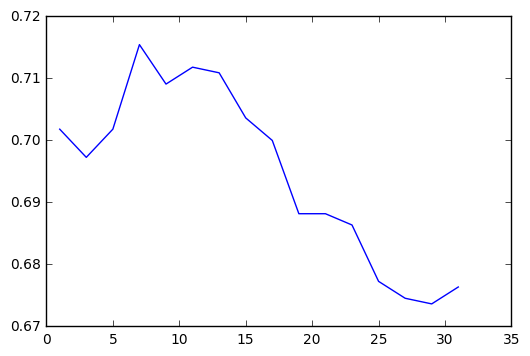

In [141]:
x = list(k_accuracies.values())
y = list(k_accuracies.keys())

plt.plot(y, x)

# 2. SVM with RBF kernel

In [174]:
parameters = {'kernel':['rbf'], 'C':[0.1, 0.5, 1, 2, 5,10, 20, 50], 'gamma': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = SVC()
clf = GridSearchCV(svr, parameters, cv=5)
clf.fit(X_train, y_train)
print("Best accuracy:", clf.best_score_,  clf.best_params_)

Best accuracy: 0.886363636364 {'gamma': 0.01, 'C': 5, 'kernel': 'rbf'}


## Classifying using the test set with the best parameters

In [178]:
knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train, y_train)
knn_acc = knn.score(X_test, y_test)

svm = SVC(kernel='rbf', C=5, gamma=0.01)
svm.fit(X_train, y_train)
svm_acc = svm.score(X_test, y_test)

print("KNN test accuracy:", knn_acc)
print("SVM test accuracy", svm_acc)

KNN test accuracy: 0.717272727273
SVM test accuracy 0.898181818182


# 3. Decision Trees

In [182]:
clf = tree.DecisionTreeClassifier()

clf.fit(X_train, y_train)
dt_acc = clf.score(X_test, y_test)
print("Decision tree test accuracy:", dt_acc)

Decision tree test accuracy: 0.915454545455


# 4. Random Forests

In [188]:
randomforest = RandomForestClassifier()

randomforest.fit(X_train, y_train)
dt_acc = randomforest.score(X_test, y_test)
print("Decision tree test accuracy:", dt_acc)

Decision tree test accuracy: 0.936363636364


# 5. Neural network

In [231]:
# One-hot encode labels
y_train_onehot = np_utils.to_categorical(y_train)
y_test_onehot = np_utils.to_categorical(y_test)
    
num_features = features.shape[1]
num_classes = len(np.unique(labels))

print(y_train_onehot.shape, y_test_onehot.shape)

model = Sequential()
model.add(Dense(num_features, input_dim=num_features, init='normal', activation='relu'))
model.add(Dense(num_classes, init='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), nb_epoch=100, batch_size=50, verbose=0)

loss, nn_acc = model.evaluate(X_test, y_test_onehot)

print("\nNeural network accuracy:", nn_acc)

(1100, 2) (1100, 2)
 832/1100 [=====================>........] - ETA: 0s
Neural network accuracy: 0.907272727273


# 6. Auto-encoder

In [523]:
input_layer = Input(shape=(num_features,))

encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(2, activation='relu')(encoded)
encoder_output = Dense(2, activation='softmax')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(num_features, activation='sigmoid')(decoded)

autoencoder = Model(input=input_layer, output=decoded)
encoder = Model(input=input_layer, output=encoder_output)

autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

autoencoder.fit(X_train, X_train,
                nb_epoch=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test), verbose=0,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder2')])

y_pred = encoder.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

np.mean(y_pred == y_test)

0.5

In [541]:
# trying with sigmoid activation function and MSE loss

input_layer = Input(shape=(num_features,))

encoded = Dense(32, activation='sigmoid')(input_layer)
encoded = Dense(16, activation='sigmoid')(encoded)
encoded = Dense(8, activation='sigmoid')(encoded)
encoded = Dense(2, activation='sigmoid')(encoded)
encoder_output = Dense(2, activation='softmax')(encoded)

decoded = Dense(8, activation='sigmoid')(encoded)
decoded = Dense(16, activation='sigmoid')(decoded)
decoded = Dense(32, activation='sigmoid')(decoded)
decoded = Dense(num_features, activation='sigmoid')(decoded)

autoencoder = Model(input=input_layer, output=decoded)
encoder = Model(input=input_layer, output=encoder_output)

autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

autoencoder.fit(X_train, X_train,
                nb_epoch=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test), verbose=0,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder2')])

y_pred = encoder.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

np.mean(y_pred == y_test)

0.52181818181818185

# Trying autoencoder classification on data D

In [481]:
import tensorflow as tf
import time

# Parameters
learning_rate = 0.01
training_epochs = 100
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 32 # 1st layer num features
n_hidden_2 = 16 # 2nd layer num features

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_features])
y = tf.placeholder("float", [None, num_classes])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_features, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, num_features])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_features])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

encoded = tf.add(tf.matmul(encoder_op, tf.Variable(tf.random_normal([16, 2]))),
                                       tf.Variable(tf.random_normal([2])))

is_correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(encoded), 1), tf.argmax(y, 1))
encoded_accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
#optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle

    total_batches = int(len(X_train)/batch_size)
    for epoch in range(training_epochs):
        start_time = time.time()
        for i in range(total_batches):
            batch_start = i * batch_size
            batch_xs = X_train[batch_start:batch_start + batch_size]
            batch_ys = y_train_onehot[batch_start:batch_start + batch_size]                 
                 
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, y: batch_ys})
                 
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

    # Applying encode and decode over test set
    encode_decode = sess.run(
        encoded_accuracy, feed_dict={X: X_test, y: y_test_onehot})
    print(encode_decode)

Epoch: 0001 cost= 1.336669803
Epoch: 0002 cost= 1.252686620
Epoch: 0003 cost= 1.194153786
Epoch: 0004 cost= 1.153623581
Epoch: 0005 cost= 1.114895344
Epoch: 0006 cost= 1.075670719
Epoch: 0007 cost= 1.042390943
Epoch: 0008 cost= 1.020548820
Epoch: 0009 cost= 1.011955380
Epoch: 0010 cost= 1.009491205
Epoch: 0011 cost= 1.008293152
Epoch: 0012 cost= 1.007159948
Epoch: 0013 cost= 1.005833626
Epoch: 0014 cost= 1.004251361
Epoch: 0015 cost= 1.002456307
Epoch: 0016 cost= 1.000298738
Epoch: 0017 cost= 0.997825623
Epoch: 0018 cost= 0.995283306
Epoch: 0019 cost= 0.992772877
Epoch: 0020 cost= 0.990368605
Epoch: 0021 cost= 0.988036036
Epoch: 0022 cost= 0.985637069
Epoch: 0023 cost= 0.983090162
Epoch: 0024 cost= 0.980468512
Epoch: 0025 cost= 0.977868617
Epoch: 0026 cost= 0.975325406
Epoch: 0027 cost= 0.972688615
Epoch: 0028 cost= 0.970006168
Epoch: 0029 cost= 0.967246771
Epoch: 0030 cost= 0.964479506
Epoch: 0031 cost= 0.961797357
Epoch: 0032 cost= 0.959145308
Epoch: 0033 cost= 0.956584752
Epoch: 003

# Trying autoencoder classification on MNIST with tensorflow

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 cost= 0.253676355
Epoch: 0002 cost= 0.200106621
Epoch: 0003 cost= 0.192717686
Epoch: 0004 cost= 0.184969246
Epoch: 0005 cost= 0.177645281
Epoch: 0006 cost= 0.172374323
Epoch: 0007 cost= 0.164328590
Epoch: 0008 cost= 0.157008827
Epoch: 0009 cost= 0.154211685
Epoch: 0010 cost= 0.148820564
Epoch: 0011 cost= 0.144056618
Epoch: 0012 cost= 0.141940832
Epoch: 0013 cost= 0.141294226
Epoch: 0014 cost= 0.137545466
Epoch: 0015 cost= 0.135654584
Epoch: 0016 cost= 0.133354381
Epoch: 0017 cost= 0.132716447
Epoch: 0018 cost= 0.130840629
Epoch: 0019 cost= 0.131154001
Epoch: 0020 cost= 0.128292441
Optimization Finished!


/home/olivier/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0.0876


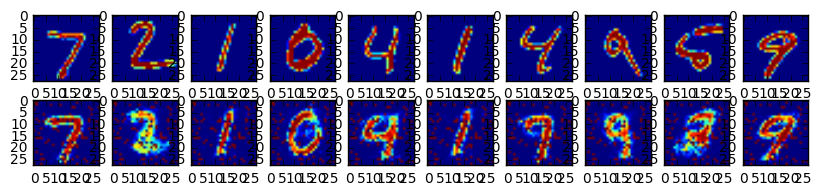

In [520]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([n_hidden_2, n_classes])),    
    'decoder_h1': tf.Variable(tf.random_normal([n_classes, n_hidden_2])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h3': tf.Variable(tf.random_normal([n_hidden_1, n_input])),    
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_classes])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_2])),    
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b3': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    
    layer_3 = tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3'])    
    return layer_3


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    
    # Decoder Hidden layer with sigmoid activation #2
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']))
    
    return layer_3

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(tf.nn.sigmoid(encoder_op))

is_correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(encoder_op), 1), tf.argmax(y, 1))
encoded_accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_pred, y_true))
#optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

    # Applying encode and decode over test set
    encoding_accuracy = sess.run(
        encoded_accuracy, feed_dict={X: mnist.test.images, y: mnist.test.labels})

    # Applying encode and decode over test set
    encode_decode = sess.run(
        y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    f.show()
    plt.draw()    
    
    print(encoding_accuracy)

In [504]:
print(encoding_accuracy)

0.0519
